
# Filtering of (mesoscale + noise) time series

The goal is to extract a mesoscale signal from noise.
Several approaches can be thought of:
- filtering based on the knowledge of mesoscale and noise autocorrelation functions.
- filtering based on the knowledge of cutoff frequency (presumably where the mesoscale and noise spectrum intersect in frequency space). We'll use optimal interpolation to do that.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal, sparse

# project figure directory
fpath=%pwd
fpath+='/figs/'


def generate_meso(t=None,T=365.*3,dt=1./24.,Tcut=50,rms=1.):
    """ generate a sea level corresponding to QG turbulence, i.e.
    a flat spectrum at frequencies lower that Tcu
        
    Parameters
    ----------
        t:
            time line in days
        T:
            time period in days, default corresponds to 3 years
        dt:
            time interval in days, default corresponds to 1h
        Tcut:
            period cutoff for the spectrum in days, default is 50 days
        rms:
            signal rms, default is 0.2
    """
    
    if t is None:
        t=np.arange(0.,T,dt)
    N=t.size
    
    # build frequency line
    omega = 2.*np.pi*np.fft.fftfreq(N,dt)
    omega_cut = 2.*np.pi/Tcut
    
    # create a distribution with right spectral properties
    eta_f = np.exp(1j*np.random.uniform(high=1.,size=N)*2.*np.pi)
    eta_f[np.where(np.abs(omega)>omega_cut)] = eta_f[np.where(np.abs(omega)>omega_cut)] \
                                * omega_cut/omega[np.where(np.abs(omega)>omega_cut)]
    
    # inverse fft
    eta=np.real(np.fft.ifft(eta_f))
    
    # renormalize
    eta = rms * eta / np.std(eta)
    
    return eta, t



In [2]:
### build time series

# mesoscale signal
eta_meso, t = generate_meso()

# add noise
noise = np.random.normal(loc=0.0, scale=eta_meso.std()/2., size=eta_meso.shape)
eta = eta_meso + noise

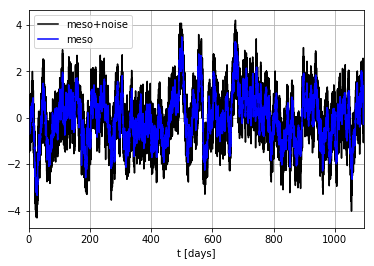

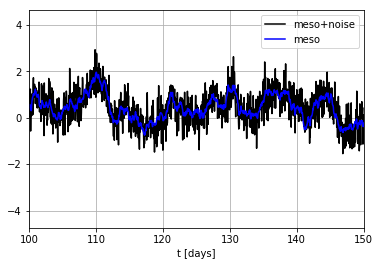

In [3]:
# plot time series
off=0.1
plt.figure()
plt.plot(t,eta,'k',label='meso+noise')
plt.plot(t,eta_meso-off*0.,'b',label='meso')
plt.grid()
plt.legend()
plt.xlim((t[0],t[-1]))
plt.xlabel('t [days]')
plt.show()

# plot time series
off=0.1
plt.figure()
plt.plot(t,eta,'k',label='meso+noise')
plt.plot(t,eta_meso-off*0.,'b',label='meso')
plt.grid()
plt.legend()
plt.xlim((100.,150.))
plt.xlabel('t [days]')
plt.show()

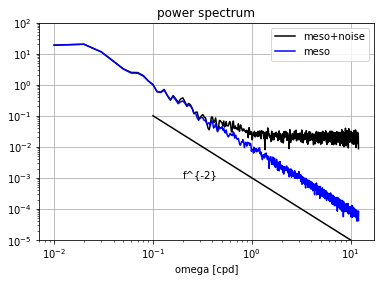

In [7]:
# compute spectrum to check it satisfies the spectrum prescribed
# compare spectra

dt=t[1]-t[0]
Nw=100/dt
f, E = signal.welch(eta, 1/dt, nperseg=Nw)
f, E_meso = signal.welch(eta_meso, 1/dt, nperseg=Nw)

# plot spectra
plt.figure()
plt.loglog(f,E,'k',label='meso+noise')
plt.loglog(f,E_meso,'b',label='meso')
fref = np.array([1e-1,1e1])
plt.loglog(fref,1e-3*fref**-2,'k')
plt.text(2*1e-1,1e-3,'f^{-2}')
plt.xlabel('omega [cpd]')
plt.ylim(1e-5,1e2)
plt.grid()
plt.legend()
plt.title('power spectrum')
plt.show()


---

## Filtering with an optimal interpolation approach


We start from the best linear estimate of $x$ given observations $y$
(Gauss-Markov theorem):

\begin{align}
\tilde{\mathbf{x}}(\tilde{\mathbf{r}}_\alpha)
&=
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_i)
\mathbf{R}_{yy}(\mathbf{r}_i,\mathbf{r}_j)^{-1}
\mathbf{y}(\mathbf{r}_j) \\
\mathbf{P}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta) &=
\mathbf{R}_{xx}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta)
-
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_j)
\mathbf{R}_{yy}(\mathbf{r}_j,\mathbf{r}_k)^{-1}
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\beta,\tilde{\mathbf{r}}_k)^t
\end{align}

The estimate is unbiased if $\langle y \rangle = x = 0$

We assume then that measurements $y$ are related to the mesoscale signal $x$ by:
$\mathbf{y}=\mathbf{E}\mathbf{x}+\mathbf{n}$

This leads to the following solution:

\begin{align}
\tilde{\mathbf{x}} &=
\mathbf{R}_{xx} \mathbf{E}^T
(\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T
+
\mathbf{R}_{nn})^{-1}
\mathbf{y}, \\
\tilde{\mathbf{n}} &=
\mathbf{y} - \mathbf{E}\tilde{\mathbf{x}}, \\
\mathbf{P} &=  \mathbf{R}_{xx} - \mathbf{R}_{xx} \mathbf{E}^t (\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T + \mathbf{R}_{nn})^{-1} \mathbf{E} \mathbf{R}_{xx}.
\end{align} 

or with the matrix inversion lemma:

\begin{align}
\tilde{\mathbf{x}} &=
( \mathbf{R}_{xx}^{-1}
+
\mathbf{E}^T \mathbf{R}_{nn}^{-1} \mathbf{E}  )^{-1} \mathbf{E}^t \mathbf{R}_{nn}^{-1}
\mathbf{y}, \\
\tilde{\mathbf{n}} &=
\mathbf{y} - \mathbf{E}\tilde{\mathbf{x}}, \\
\mathbf{P} &=  ( \mathbf{R}_{xx}^{-1} + \mathbf{E}^t \mathbf{R}_{nn}^{-1} \mathbf{E})^{-1}.
\end{align} 


In the present case: $\mathbf{E}=\mathbf{I}$



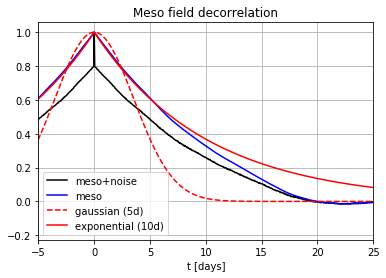

In [8]:
#
#  compute the autocorrelation and plot it

def get_autocor(eta,t):
    C = signal.correlate(eta,eta)
    imax = eta.size-1 # after trial&error
    lags = np.arange(C.size)*(t[1]-t[0])
    lags += -lags[imax]
    C *= 1/C[imax]
    return C, lags

C_meso, lags = get_autocor(eta_meso,t)
C, lags = get_autocor(eta,t)

fig = plt.figure()
ax=plt.subplot(111)
plt.plot(lags,C,'k',label='meso+noise')
plt.plot(lags,C_meso,'b',label='meso')
plt.plot(lags,np.exp(-(lags/5.)**2),'r--',label='gaussian (5d)')
plt.plot(lags,np.exp(-np.abs(lags/10.)),'r',label='exponential (10d)')
plt.xlim((-5.,25.))
plt.grid()
plt.xlabel('t [days]')
plt.title('Meso field decorrelation')
plt.legend(loc=3)
plt.show()






Noise std = 0.498425
Meso std = 1.000000


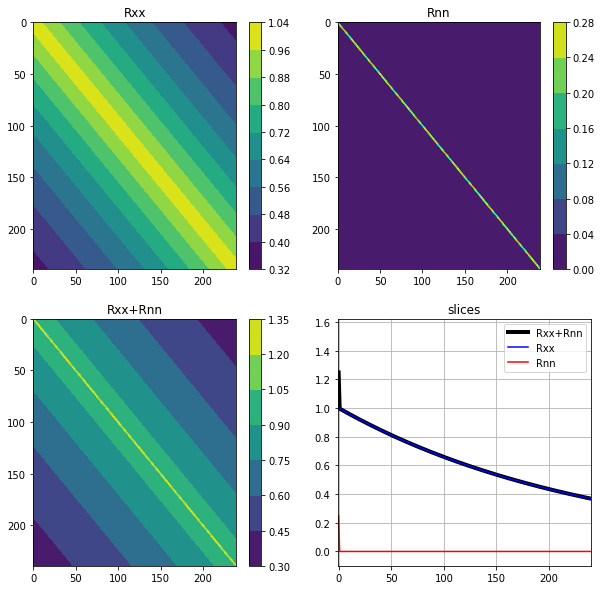

In [11]:
#
# select a smaller time window and filter data
#

#
t0 = 100.
Twin = 10.
iwin = np.where((t>=t0)&(t<t0+Twin))[0]

# generate the sliding window
dt = t[1]-t[0]
twin = np.arange(-Twin*.5,Twin*.5,dt)

# setup estimation  
E = np.eye(twin.size)

# generate covariance matrices
T1, T2 = np.meshgrid(twin,twin)
#Rxx = np.exp(-((T1-T2)/5.)**2) * eta_meso.std()**2 # gaussian
Rxx = np.exp(-np.abs((T1-T2)/10.)) * eta_meso.std()**2 # exponential
#
Rnn = np.eye(twin.size) * (noise.std()*1.)**2

print 'Noise std = %f' %noise.std()
print 'Meso std = %f' %eta_meso.std()


plt.figure(figsize=(10,10))
#
plt.subplot(2,2,1)
plt.contourf(Rxx)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Rxx')
#
plt.subplot(2,2,2)
plt.contourf(Rnn)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Rnn')
#
plt.subplot(2,2,3)
plt.contourf(Rxx+Rnn)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Rxx+Rnn')
#
plt.subplot(2,2,4)
plt.plot(Rxx[0,:]+Rnn[0,:],'k',lw=4,label='Rxx+Rnn')
plt.plot(Rxx[0,:],'b',label='Rxx')
plt.plot(Rnn[0,:],'r',label='Rnn')
plt.grid()
plt.xlim((-1,Rxx[0,:].size))
plt.ylim((-.1*Rxx[0,0],1.3*(Rxx[0,0]+Rnn[0,0])))
plt.legend(loc=1)
plt.title('slices')
plt.show()




# Note on the stability of the inversion

We have two options in order to compute the inversion:

### option 1

\begin{align}
\tilde{\mathbf{x}} &=
\mathbf{R}_{xx} \mathbf{E}^T
(\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T
+
\mathbf{R}_{nn})^{-1}
\mathbf{y}, \\
\mathbf{P} &=  \mathbf{R}_{xx} - \mathbf{R}_{xx} \mathbf{E}^t (\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T + \mathbf{R}_{nn})^{-1} \mathbf{E} \mathbf{R}_{xx},
\end{align} 

The first option is stable in general.


### option 2

With the matrix inversion lemma:

\begin{align}
\tilde{\mathbf{x}} &=
( \mathbf{R}_{xx}^{-1}
+
\mathbf{E}^T \mathbf{R}_{nn}^{-1} \mathbf{E}  )^{-1} \mathbf{E}^t \mathbf{R}_{nn}^{-1}
\mathbf{y}, \\
\mathbf{P} &=  ( \mathbf{R}_{xx}^{-1} + \mathbf{E}^t \mathbf{R}_{nn}^{-1} \mathbf{E})^{-1}.
\end{align} 

For long windows, option 2 is unstable and an SVD decomposition is necessary:
\begin{align}
\mathbf{R}_{xx} &= \mathbf{U} \mathbf{S} \mathbf{V}^T, \\
\mathbf{R}_{xx} &\sim \mathbf{\tilde{U}} \mathbf{\tilde{S}} \mathbf{\tilde{V}}^T, \\
\mathbf{\tilde{U}} &= \mathbf{U} [:,:k], \\
\mathbf{\tilde{S}} &= \mathbf{S} [:k,:k], \\
\mathbf{\tilde{V}} &= \mathbf{V} [:,:k].
\end{align}
The solution of the inversion can then be written as:
\begin{align}
\tilde{\mathbf{x}} &=
\mathbf{\tilde{U}}
( \mathbf{\tilde{S}}^{-1}
+
\mathbf{\tilde{V}}^T \mathbf{E}^T \mathbf{R}_{nn}^{-1} \mathbf{E} \mathbf{\tilde{U}} )^{-1} 
\mathbf{\tilde{V}}^T
\mathbf{E}^T \mathbf{R}_{nn}^{-1}
\mathbf{y},
\end{align}




In [ ]:
#
# Option 1
#

#
#leta = eta_meso[iwin,None]
leta = eta[iwin,None]
#leta += -leta.mean()

#P = np.dot(E,np.dot(Rxx.todense(),E.T)) + Rnn
M = np.dot(E,np.dot(Rxx,E.T)) + Rnn
x_tilde = Rxx.dot(np.dot(E.T,np.linalg.solve(M,leta)))
P = np.diag( Rxx - np.dot(Rxx, np.dot(E.T, np.dot( np.linalg.inv(M), np.dot(E,Rxx) ) ) ) )
#
#P = np.dot(E,np.dot(Rxx.todense(),E.transpose())) + Rnn
#x_tilde = Rxx.dot(np.dot(E.T,sparse.linalg.spsolve(P,leta)))
#x_tilde = Rxx.dot(E.transpose().dot(sparse.linalg.spsolve(P,leta)))

# plot time series
off=0.1
plt.figure()
plt.plot(t,eta,'k',label='meso+noise')
plt.plot(t,eta_meso,'b',label='meso')
plt.plot(t[iwin],x_tilde,'r',label='inversion')
plt.plot(t[iwin],x_tilde[:,0] + 1.5*np.sqrt(P),'r-',lw=.5)
plt.plot(t[iwin],x_tilde[:,0] - 1.5*np.sqrt(P),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()


In [ ]:
#
# Option 1 with fewer svd vectors
#

#S = np.diag(s)    
#P = np.dot(U, np.dot(S, Vt))

k=10
#
S = np.diag(s[:k])
Pr = np.dot(U[:,:k], np.dot(S, Vt[:k,:]))
#
iS = np.diag(1/s[:k])
iMr = np.dot(Vt[:k,:].T,np.dot(iS,U[:,:k].T))

#x_tilde = Rxx.dot(E.transpose().dot(sparse.linalg.spsolve(P,leta)))
#x_tilde = Rxx.dot(np.dot(E.T,np.linalg.solve(Pr,leta)))
#x_tilde = np.dot(Rxx.todense(),np.dot(E.T,np.dot(iPr,leta)))
x_tilde = np.dot(Rxx,np.dot(E.T,np.dot(iMr,leta)))
P = np.diag( Rxx - np.dot(Rxx, np.dot(E.T, np.dot( iMr, np.dot(E,Rxx) ) ) ) )


# plot time series
off=0.1
plt.figure()
plt.plot(t,eta,'k',label='meso+noise')
plt.plot(t,eta_meso,'b',label='meso')
plt.plot(t[iwin],x_tilde,'r',label='inversion')
plt.plot(t[iwin],x_tilde[:,0] + 1.5*np.sqrt(P),'r-',lw=.5)
plt.plot(t[iwin],x_tilde[:,0] - 1.5*np.sqrt(P),'r-',lw=.5)
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()

# reconstructed P
plt.figure()
plt.contourf(Pr,20)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('P from SVD')
plt.show()


In [ ]:
#
# Option 2
#

#
#leta = eta_meso[iwin,None]
leta = eta[iwin,None]
#leta += -leta.mean()

# does not work as SVD should be used prior to inversion calculations
iRnn = np.linalg.inv(Rnn)
#iRnn = np.eye(twin.size) * 1./(noise.std()*1.)**2

# do a SVD decomposition on Rxx to get rid of high frequencies
#iRxx = np.linalg.inv(Rxx)
#U,s,Vt = np.linalg.svd(Rxx.todense())
U,s,Vt = np.linalg.svd(Rxx)
k=20
S = np.diag(s[:k])
iS = np.diag(1./s[:k])
iRxx = np.dot(Vt[:k,:].T,np.dot(iS,U[:,:k].T))
M = iRxx + np.dot(E.T,np.dot(iRnn,E))
#iP = np.linalg.inv(P) # unstable
iM = np.dot(U[:,:k], np.dot( np.linalg.inv( iS + 
                np.dot(Vt[:k,:], np.dot(np.dot(E.T,np.dot(iRnn,E)), U[:,:k] ) ) ), Vt[:k,:] ) )

#x_tilde = sparse.linalg.spsolve(P,np.dot(E.transpose(),np.dot(iRnn,leta)))
#x_tilde = np.linalg.solve(P,np.dot(E.transpose(),np.dot(iRnn,leta)))
x_tilde = np.dot(iM,np.dot(E.transpose(),np.dot(iRnn,leta)))

# standard approach, unstable
M2u = np.linalg.inv(Rxx) + np.dot(E.transpose(),np.dot(iRnn,E))
iM2u = np.linalg.inv(M2u)
x2u_tilde = np.dot(iM2u,np.dot(E.transpose(),np.dot(iRnn,leta)))


# plot time series
off=0.1
plt.figure()
plt.plot(t,eta,'k',label='meso+noise')
plt.plot(t,eta_meso,'b',label='meso')
plt.plot(t[iwin],x_tilde,'r',label='inversion',lw=2)
plt.plot(t[iwin],x2u_tilde,'-',color='orange',label='inversion no SVD')
plt.grid()
plt.legend()
plt.xlim((t0,t0+Twin))
plt.show()


# Details about the SVD
plt.figure()
plt.plot(s,'d')
plt.title('eigenvalues')
plt.show()

plt.figure()
plt.plot(U[:,:10])
plt.title('eigenvectors')
plt.grid()
plt.show()

plt.figure()
#plt.contourf(iRxx)
#plt.contourf(np.linalg.inv(iRxx)) # unstable
plt.contourf(np.dot(U[:,:k],np.dot(S,Vt[:k,:])))
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Rxx estimation')
plt.show()


In [ ]:

#
# Look at the SVD decomposition of the combined covariance matrix
#

M = np.dot(E,np.dot(Rxx,E.T)) + Rnn
U,s,Vt = np.linalg.svd(M)
#U,s,Vt = np.linalg.svd(Rxx.todense())
#u,s,vt = sparse.linalg.svds(P)


plt.figure()
plt.contourf(M,20)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('M')
plt.show()

plt.figure()
plt.plot(M[:,0])
plt.title('M[:,0]')
plt.show()

plt.figure()
plt.plot(s,'d')
plt.title('eigenvalues of the SVD')
plt.grid()
plt.show()


plt.figure()
plt.plot(U[:,:10],'k-')
plt.title('U[:,:10]')
plt.show()

plt.figure()
off=.1
#for n in xrange(u.shape[1]):
for n in xrange(10):
    plt.plot(U[:,n]+off*n,'k')
plt.show()

print 's[0:5] :',s[0:5]
print 's[-5:] :',s[-5:]



## Note on inversion with correlated variables

We want to satisfy:

$y=Mx$

with $y$ being the original time series, $x$ the filtered time series ($\eta_\mathrm{slow}$ and tidal harmonics), $M$ the observation operator.
The problems is thus formulated variationally in terms of the minimization of a cost function:

$||y-Mx||_C$

where $C$ is the matrix correlation.
The solution of this problem is:

$x = (M^t C^{-1} M)^{-1}  M^t C^{-1} y$

Compared to a BLUE, there is no prior.


## Note on optimal interpolation

Wunsch book (electronic)

$\mathbf{y}=\mathbf{E}\mathbf{x}+\mathbf{n}$  (2.87)

Page 114:

''

But there is another, very different, approach to obtaining estimates of the solution to
equation sets like (2.87), directed more clearly toward the physical goal: to find an estimate
$\tilde{x}$ which deviates as little as possible in the mean-square from the true solution. That is, we
wish to minimize the statistical quantities $\langle (\tilde{x}_i −x_i )^2\rangle$ for all i

Let us make some suppositions about what is usually called ''prior information.'' In particular, suppose we have an estimate of the low-order statistics describing x, that is, specifying its mean and second moments:

$\langle \mathbf{x}\rangle=0$ and 
$\langle \mathbf{x}(\mathbf{r_i}) \mathbf{x}(\mathbf{r_j})^t \rangle=\mathbf{R_{xx}(\mathbf{r}_i,\mathbf{r}_j)}$


Now suppose that we have some observations, yi, as a function of the same coordinate ri, with a known, zero mean, and second moments:

$\langle \mathbf{y}(\mathbf{r_i}) \mathbf{y}(\mathbf{r_j})^t \rangle=\mathbf{R_{yy}(\mathbf{r}_i,\mathbf{r}_j)}$

$\langle \mathbf{x}(\mathbf{r_i}) \mathbf{y}(\mathbf{r_j})^t \rangle=\mathbf{R_{xy}(\mathbf{r}_i,\mathbf{r}_j)}$

Could the measurements be used to make an estimate of $\mathbf{x}$ at a point $\mathbf{r}_\alpha$ where no measurement is available? Or could many measurements be used to obtain a better estimate even at points where there exists a measurement? The idea is to exploit the concept that finite covariances carry predictive capabilities from known variables to unknown ones. A specific example would be to suppose the measurements are of temperature, $y(r_j) = y_0(r_j)+n(r_j)$, where $n$ is the noise and temperature estimates are sought at different locations, perhaps on a regular grid $\tilde{\mathbf{r}}_\alpha$, $\alpha=1,2,\dots,N$. This special problem is one of gridding or mapmaking (the tilde is placed on $\mathbf{r}_\alpha$ as a device to emphasize that this is a location where an estimate is sought; the numerical values of these places or labels are assumed known). Alternatively, and somewhat more interesting, perhaps the measurements are more indirect, with $y(r_i)$ representing a velocity field component at depth in a fluid and believed connected, through a differential equation, to the temperature field. We might want to estimate the temperature from measurements of the velocity.

''

We search for a linear estimate:

$\tilde{x}(\tilde{\mathbf{r}}_\alpha) = \sum_{j=1}^M B(\tilde{\mathbf{r}}_\alpha, \mathbf{r}_j) y(\mathbf{r}_j)$
(or more compactly: 
$\tilde{\mathbf{x}}=\mathbf{B}\mathbf{y}$)

which minimizes the diagonal of the covariance of the estimate:

$\mathbf{P}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta)
=\langle (\tilde{x}(\tilde{\mathbf{r}}_\alpha) - x(\tilde{\mathbf{r}}_\alpha)) 
\times (\tilde{x}(\tilde{\mathbf{r}}_\beta) - x(\tilde{\mathbf{r}}_\beta)) \rangle
=\langle (\tilde{\mathbf{x}}-\mathbf{x}) (\tilde{\mathbf{x}}-\mathbf{x})^t \rangle$

Substituing the linear estimate leads to:

$
\mathbf{P}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta)
=
\langle (\mathbf{B}\mathbf{y}-\mathbf{x}) (\mathbf{B}\mathbf{y}-\mathbf{x})^t \rangle
=
\mathbf{B} \langle  \mathbf{y} \mathbf{y}^t \rangle \mathbf{B}^t
- \langle  \mathbf{x} \mathbf{y}^t \rangle \mathbf{B}^t
- \mathbf{B} \langle  \mathbf{y} \mathbf{x}^t \rangle
+ \langle  \mathbf{x} \mathbf{x}^t \rangle 
$

This can be written as:

$
\mathbf{P}
=
\mathbf{B} \mathbf{R}_{yy} \mathbf{B}^t
- \mathbf{R}_{xy} \mathbf{B}^t
- \mathbf{B} \mathbf{R}_{xy}^t
+ \mathbf{R}_{xx}
$

''
Notice that because $\mathbf{R}_{xx}$ represents the moments of x evaluated at the estimation positions, it is a function of $\tilde{\mathbf{r}}_\alpha$, $\tilde{\mathbf{r}}_\beta$, whereas $\mathbf{R}_{xy}$ involves covariances of $y$ at the data positions with $x$ at the estimation positions, and is consequently a function $\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_j)$.
''

We complete the square by adding and substracting $\mathbf{R}_{xy} \mathbf{R}_{yy}^{-1} \mathbf{R}_{xy}^t$:

$
\mathbf{P}
=
(\mathbf{B} - \mathbf{R}_{xy} \mathbf{R}_{yy}^{-1})
\mathbf{R}_{yy}^{-1}
(\mathbf{B} - \mathbf{R}_{xy} \mathbf{R}_{yy}^{-1})^t
- \mathbf{R}_{xy} \mathbf{R}_{yy}^{-1} \mathbf{R}_{xy}^t
+ \mathbf{R}_{xx}.
$

where all three terms are positive. We thus must have:

$
B(\tilde{\mathbf{r}}_\alpha, \mathbf{r}_j)
=
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_j)
\mathbf{R}_{yy}(\mathbf{r}_i,\mathbf{r}_j)^{-1}
= \mathbf{R}_{xy} \mathbf{R}_{yy}^{-1}
$

and the solution is:

$
\tilde{\mathbf{x}}(\tilde{\mathbf{r}}_\alpha)
=
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_j)
\mathbf{R}_{yy}(\mathbf{r}_i,\mathbf{r}_j)^{-1}
\mathbf{y}(\mathbf{r}_j)
$

and the estimate covariance is then:

$
\mathbf{P}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta) =
\mathbf{R}_{xx}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_\beta)
-
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\alpha,\tilde{\mathbf{r}}_j)
\mathbf{R}_{yy}(\mathbf{r}_j,\mathbf{r}_k)^{-1}
\mathbf{R}_{xy}(\tilde{\mathbf{r}}_\beta,\tilde{\mathbf{r}}_k)^t
$

If $\mathbf{E}\mathbf{x}+\mathbf{n}=\mathbf{y}$,
the measurement covariance $\mathbf{R}_{yy}$ is given by:

$
\mathbf{R}_{yy}
=
\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T
+
\mathbf{R}_{nn}
$

If $n$ and $x$ are assumed to be uncorrelated (not necessary):

$
\mathbf{R}_{xy}
=
\mathbf{R}_{xx} \mathbf{E}^T
$

The solution can then be written as:

\begin{align}
\tilde{\mathbf{x}} &=
\mathbf{R}_{xx} \mathbf{E}^T
(\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T
+
\mathbf{R}_{nn})^{-1}
\mathbf{y}, \\
\tilde{\mathbf{n}} &=
\mathbf{y} - \mathbf{E}\tilde{\mathbf{x}}, \\
\mathbf{P} &=  \mathbf{R}_{xx} - \mathbf{R}_{xx} \mathbf{E}^t (\mathbf{E} \mathbf{R}_{xx} \mathbf{E}^T + \mathbf{R}_{nn})^{-1} \mathbf{E} \mathbf{R}_{xx}.
\end{align} 

or with the matrix inversion lemma:

\begin{align}
\tilde{\mathbf{x}} &=
( \mathbf{R}_{xx}^{-1}
+
\mathbf{E}^T \mathbf{R}_{nn}^{-1} \mathbf{E}  )^{-1} \mathbf{E}^t \mathbf{R}_{nn}^{-1}
\mathbf{y}, \\
\tilde{\mathbf{n}} &=
\mathbf{y} - \mathbf{E}\tilde{\mathbf{x}}, \\
\mathbf{P} &=  ( \mathbf{R}_{xx}^{-1} + \mathbf{E}^t \mathbf{R}_{nn}^{-1} \mathbf{E})^{-1}.
\end{align} 




Matrix inversion lemma (2.36):

\begin{align}
\{ \mathbf{C} - \mathbf{B}^t \mathbf{A}^{-1} \mathbf{B} \}^{-1} &=
\{ \mathbf{I} - \mathbf{C}^{-1} \mathbf{B}^t \mathbf{A}^{-1} \mathbf{B} \}^{-1}  \mathbf{C}^{-1} \\
&= \mathbf{C}^{-1} 
- \mathbf{C}^{-1} \mathbf{B}^t ( \mathbf{B} \mathbf{C}^{-1} \mathbf{B}^t - \mathbf{A})^{-1} \mathbf{B} \mathbf{C}^{-1}
\end{align}

A variant is:

\begin{align}
\mathbf{A} \mathbf{B}^t (\mathbf{C} + \mathbf{B} \mathbf{A} \mathbf{B}^t )^{-1}
=
( \mathbf{A}^{-1} + \mathbf{B}^t \mathbf{C}^{-1} \mathbf{B} )^{-1} \mathbf{B}^t \mathbf{C}^{-1}.
\end{align}

